In [1]:
import torch
import numpy as np

class QuantizerScheme:  
    def __init__(self, t, b):  
        self.b = np.floor(b)  
        self.t = t
        self.incr = 1
        
        if b <= 0:
            raise Exception("QuantizerScheme: 'b' must be greater than 0.")
        
        if t <= 0 or t >= 1:
            raise Exception("QuantizerScheme: 't' must be between 0 and 1.")
        
        #Bitwidth (b) produces a number of values equal to 2^b
        bs = 2 ** b
        
        #Value 0 is always 0. Value Max is always 1.
        self.vals = np.zeros(bs)
        self.vals[bs - 1] = 1
        
        #For the values in between, it is equally spaced gaps between t and 1, including t.
        #If bitwidth is 1, then only 0 and 1 are options.
        
        if b > 1:
            self.incr = (1 - t) / (bs - 2) #The increment for steps between t and 1
            #valuesToCreate
            vtc = bs - 2
            for i in range(vtc):
                nv = t + (i * self.incr)
                self.vals[i + 1] = nv
                
        print(self.vals)
    
    @torch.no_grad()
    def Quantize(self, val):
        low = 0
        high = 1
        neg = 1
        if val < 0:
            neg = -1
        val = abs(val)
        for i in range(self.vals.__len__()):
            if val == self.vals[i]:
                low = val
                high = val
            if val > self.vals[i]:
                if i != self.vals.__len__() - 1:
                    low = self.vals[i]
                    high = self.vals[i + 1]
        
        if low == high: #Exact match
            return val
        else:
            sampl = np.random.uniform(low=low, high=high) - low
            hprob = (val - low)/self.incr
            prob = sampl/self.incr
            #If prob < hprob, round to the high, else round to the low
            if prob < hprob:
                val = high
            else:
                val = low
        return (val * neg)
            #print(prob, hprob)
        #print(val)        
        #print(low)
        #print(high)

In [115]:
import torch
from torch.optim.optimizer import Optimizer, required
import torch.optim._functional as _F

class IntOpt(Optimizer): #Intensity Optimizer
    def __init__(self, params, t, b, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, *, maximize=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        self.qs = QuantizerScheme(t, b)
            
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, t=t, b=b)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(IntOpt, self).__init__(params, defaults)
            
    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            t = group['t']
            b = group['b']
            
            lr = group['lr']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            _F.sgd(params_with_grad,
                  d_p_list,
                  momentum_buffer_list,
                  weight_decay=weight_decay,
                  momentum=momentum,
                  lr=lr,
                  dampening=dampening,
                  nesterov=False)

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

            #First, sparsify by t
            #Second, quantize by b
            
            for p in group['params']:
                if(p.shape.__len__() > 0):
                    zs = torch.zeros(p.shape)
                    p = torch.where(p > t, p, zs)
                    p = p.detach().apply_(self.qs.Quantize)
                
        return loss

In [116]:
import torch
import torchvision

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [117]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, t):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        nn.init.uniform(self.conv1.weight, t, 1)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

def train(epoch, ex):
    networks[ex].train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizers[ex].zero_grad()
        output = networks[ex](data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizers[ex].step()
        if batch_idx % log_interval == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #    epoch, batch_idx * len(data), len(train_loader.dataset),
            #    100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
          #torch.save(network.state_dict(), '/results/model.pth')
          #torch.save(optimizer.state_dict(), '/results/optimizer.pth')
    
def test(ex):
    networks[ex].eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = networks[ex](data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



In [118]:

networks = [
    Net(0),
    Net(.1),
    Net(.1),
    Net(.1),
    Net(.1),
    Net(.1)
]


optim0 = optim.SGD(networks[0].parameters(), lr=learning_rate, momentum=momentum)
optim1 = IntOpt(networks[1].parameters(), .1, 1, lr=learning_rate, momentum=momentum)
optim2 = IntOpt(networks[2].parameters(), .1, 2, lr=learning_rate, momentum=momentum)
optim3 = IntOpt(networks[3].parameters(), .1, 3, lr=learning_rate, momentum=momentum)
optim4 = IntOpt(networks[4].parameters(), .1, 4, lr=learning_rate, momentum=momentum)
optim5 = IntOpt(networks[5].parameters(), .1, 5, lr=learning_rate, momentum=momentum)
optimizers = [optim0, optim1, optim2, optim3, optim4, optim5]

glabels = [
    "Baseline SGD",
    "IntOpt .1 , 1",
    "IntOpt .1 , 2",
    "IntOpt .1 , 3",
    "IntOpt .1 , 4",
    "IntOpt .1 , 5"
]

starts = []
ends = []
list_train_losses = []
list_test_losses = []



[0. 1.]
[0.   0.1  0.55 1.  ]
[0.   0.1  0.25 0.4  0.55 0.7  0.85 1.  ]
[0.         0.1        0.16428571 0.22857143 0.29285714 0.35714286
 0.42142857 0.48571429 0.55       0.61428571 0.67857143 0.74285714
 0.80714286 0.87142857 0.93571429 1.        ]
[0.   0.1  0.13 0.16 0.19 0.22 0.25 0.28 0.31 0.34 0.37 0.4  0.43 0.46
 0.49 0.52 0.55 0.58 0.61 0.64 0.67 0.7  0.73 0.76 0.79 0.82 0.85 0.88
 0.91 0.94 0.97 1.  ]


<ipython-input-117-424fa7089721>:14: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(self.conv1.weight, t, 1)


In [119]:
import datetime
for ex in range(1):
    starts.append(datetime.datetime.now())
    print("Started Ex. {} at {}".format(ex, datetime.datetime.now()))
    train_counter = []
    train_losses = []
    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
    for epoch in range(1, n_epochs + 1):
        train(epoch, ex)
        test(ex)
    ends.append(datetime.datetime.now())
    list_train_losses.append(train_losses)
    list_test_losses.append(test_losses)
    print("Ended Ex. {} at {}".format(ex, datetime.datetime.now()))

Started Ex. 0 at 2021-12-02 16:40:51.208044


<ipython-input-117-424fa7089721>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.1649, Accuracy: 9493/10000 (95%)


Test set: Avg. loss: 0.1210, Accuracy: 9636/10000 (96%)


Test set: Avg. loss: 0.1140, Accuracy: 9632/10000 (96%)

Ended Ex. 0 at 2021-12-02 16:43:19.501987


Ex. 0 Timelapse: 0:00:54.427757
Ex. 1 Timelapse: 0:06:03.875713
Ex. 2 Timelapse: 0:07:19.264835
Ex. 3 Timelapse: 0:09:37.731516
Ex. 4 Timelapse: 0:13:16.703091
Ex. 5 Timelapse: 0:20:20.598793


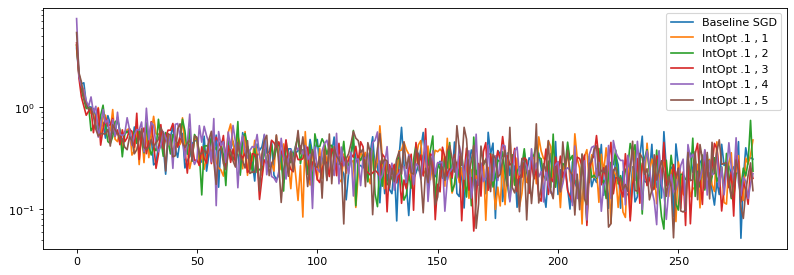

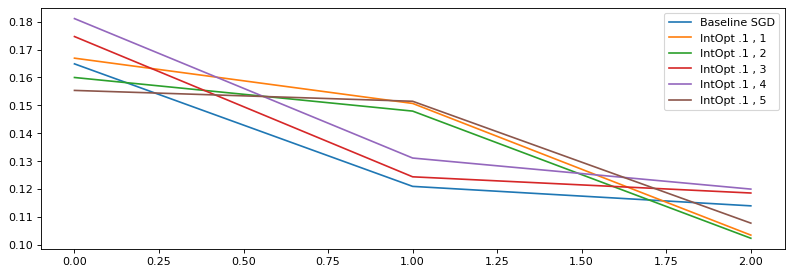

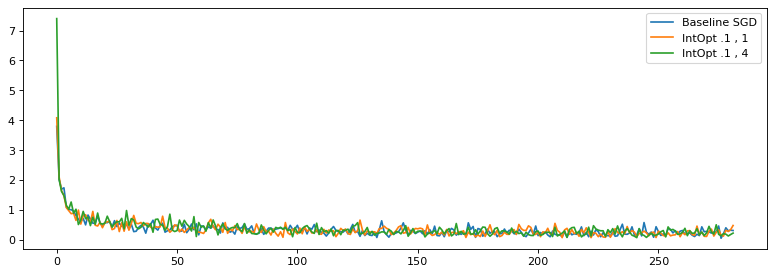

In [63]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

for i in range(6):
    diff = ends[i] - starts[i]
    print("Ex. {} Timelapse: {}".format(i, diff))

figure(figsize=(12,4), dpi=80)
plt.yscale('log')
for i in range(6):
    plt.plot(list_train_losses[i], label=glabels[i])
plt.legend()
plt.show()
figure(figsize=(12,4), dpi=80)
for i in range(6):
    plt.plot(list_test_losses[i], label=glabels[i])
plt.legend()
plt.show()
figure(figsize=(12,4), dpi=80)
plt.plot(list_train_losses[0], label=glabels[0])
plt.plot(list_train_losses[1], label=glabels[1])
plt.plot(list_train_losses[4], label=glabels[4])
plt.legend()
plt.show()


In [64]:
list_train_losses

[[3.7962262630462646,
  2.021869421005249,
  1.6940298080444336,
  1.739530086517334,
  1.0948621034622192,
  1.010327935218811,
  1.0074106454849243,
  0.9631370902061462,
  0.8076847791671753,
  0.6889281272888184,
  0.6151847243309021,
  0.7134132981300354,
  0.4992952048778534,
  0.8291528224945068,
  0.6872714757919312,
  0.5548318028450012,
  0.5552022457122803,
  0.8008778095245361,
  0.5672378540039062,
  0.4557487368583679,
  0.5805997848510742,
  0.5725541710853577,
  0.615723192691803,
  0.42735427618026733,
  0.6415929198265076,
  0.4423179030418396,
  0.5586226582527161,
  0.45018452405929565,
  0.474052369594574,
  0.5146543979644775,
  0.3637566566467285,
  0.5231351852416992,
  0.27320054173469543,
  0.2868514657020569,
  0.4125642776489258,
  0.48314476013183594,
  0.42765119671821594,
  0.22122828662395477,
  0.5151686072349548,
  0.511991024017334,
  0.6554686427116394,
  0.39339157938957214,
  0.32352492213249207,
  0.48424839973449707,
  0.5545769333839417,
  0.254

In [65]:
list_test_losses

[[0.16488482055664064, 0.12097553482055665, 0.113997314453125],
 [0.16692750396728515, 0.15070184783935547, 0.10350663146972656],
 [0.15999976959228515, 0.14795334014892578, 0.1023876594543457],
 [0.17467385711669922, 0.12440323028564453, 0.11859620590209961],
 [0.18110604400634767, 0.13113295135498046, 0.12000023574829101],
 [0.15536807098388672, 0.1514769500732422, 0.10780672912597657]]

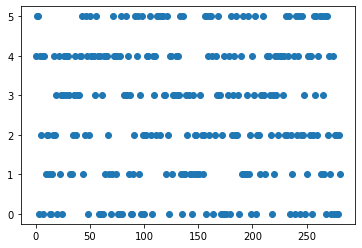

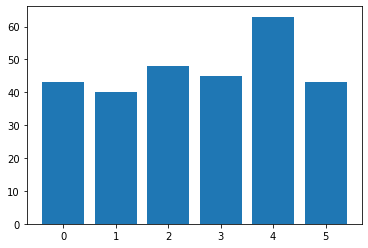

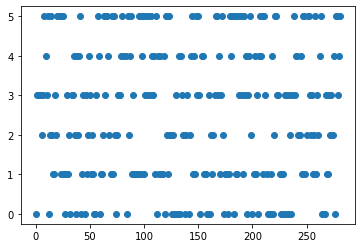

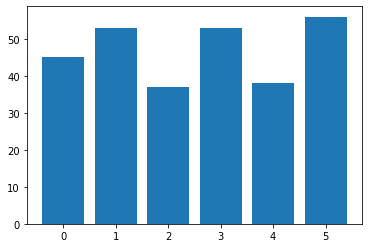

In [66]:
worst = []
best = []
for i in range(282):
    vl = [
            list_train_losses[0][i],
            list_train_losses[1][i],
            list_train_losses[2][i],
            list_train_losses[3][i],
            list_train_losses[4][i],
            list_train_losses[5][i]
         ]
    max_index = vl.index(max(vl))
    min_index = vl.index(min(vl))
    worst.append(max_index)
    best.append(min_index)
    
w0 = worst.count(0)
w1 = worst.count(1)
w2 = worst.count(2)
w3 = worst.count(3)
w4 = worst.count(4)
w5 = worst.count(5)
wList = [w0, w1, w2, w3, w4, w5]
plt.plot(worst, label="Highest Loss", linestyle="", marker="o")
plt.show()
plt.bar(range(6), wList)
plt.show()

b0 = best.count(0)
b1 = best.count(1)
b2 = best.count(2)
b3 = best.count(3)
b4 = best.count(4)
b5 = best.count(5)
bList = [b0, b1, b2, b3, b4, b5]
plt.plot(best, label="Lowest Loss", linestyle="", marker="o")
plt.show()
plt.bar(range(6), bList)
plt.show()

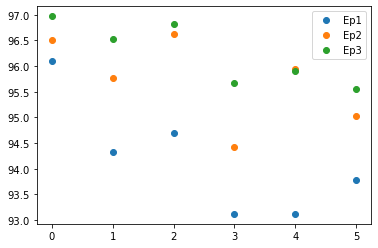

In [67]:
accs = [[96.09,96.5,96.97],[94.33,95.76,96.53],[94.69,96.62,96.82],[93.12,94.43,95.67],[93.12,95.95,95.91],[93.78,95.03,95.56]]
plt.plot(range(6), [a[0] for a in accs], linestyle="", marker="o", label="Ep1")
plt.plot(range(6), [a[1] for a in accs], linestyle="", marker="o", label="Ep2")
plt.plot(range(6), [a[2] for a in accs], linestyle="", marker="o", label="Ep3")
plt.legend()
plt.show()

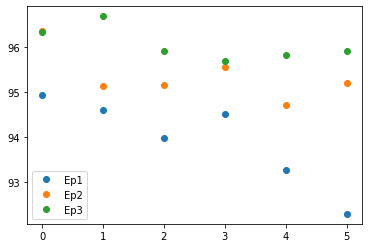

In [68]:
accs = [[94.93,96.36,96.32],[94.60,95.13,96.68],[93.99,95.15,95.92],[94.51,95.55,95.69],[93.27,94.72,95.83],[92.30,95.19,95.90]]
plt.plot(range(6), [a[0] for a in accs], linestyle="", marker="o", label="Ep1")
plt.plot(range(6), [a[1] for a in accs], linestyle="", marker="o", label="Ep2")
plt.plot(range(6), [a[2] for a in accs], linestyle="", marker="o", label="Ep3")
plt.legend()
plt.show()

In [109]:
orig1 = networks[1].fc1.weight.clone()
orig2 = networks[1].fc2.weight.clone()

In [112]:
test(1)
networks[1].fc1.weight = torch.nn.Parameter(orig1)
networks[1].fc2.weight = torch.nn.Parameter(orig2)
test(1)

<ipython-input-91-424fa7089721>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.1897, Accuracy: 9394/10000 (94%)


Test set: Avg. loss: 0.1897, Accuracy: 9394/10000 (94%)



In [113]:
qsn = QuantizerScheme(.1, 8)
test(0)
x = networks[0].fc1.weight
x = x.detach().apply_(qsn.Quantize)
fz = x[x==0].__len__()
ft = x.shape[0]*x.shape[1]
print(fz/ft)
y = networks[0].fc2.weight
y = y.detach().apply_(qsn.Quantize)
fz = y[y==0].__len__()
ft = y.shape[0]*y.shape[1]
print(fz/ft)
test(0)

[0.         0.1        0.10354331 0.10708661 0.11062992 0.11417323
 0.11771654 0.12125984 0.12480315 0.12834646 0.13188976 0.13543307
 0.13897638 0.14251969 0.14606299 0.1496063  0.15314961 0.15669291
 0.16023622 0.16377953 0.16732283 0.17086614 0.17440945 0.17795276
 0.18149606 0.18503937 0.18858268 0.19212598 0.19566929 0.1992126
 0.20275591 0.20629921 0.20984252 0.21338583 0.21692913 0.22047244
 0.22401575 0.22755906 0.23110236 0.23464567 0.23818898 0.24173228
 0.24527559 0.2488189  0.2523622  0.25590551 0.25944882 0.26299213
 0.26653543 0.27007874 0.27362205 0.27716535 0.28070866 0.28425197
 0.28779528 0.29133858 0.29488189 0.2984252  0.3019685  0.30551181
 0.30905512 0.31259843 0.31614173 0.31968504 0.32322835 0.32677165
 0.33031496 0.33385827 0.33740157 0.34094488 0.34448819 0.3480315
 0.3515748  0.35511811 0.35866142 0.36220472 0.36574803 0.36929134
 0.37283465 0.37637795 0.37992126 0.38346457 0.38700787 0.39055118
 0.39409449 0.3976378  0.4011811  0.40472441 0.40826772 0.411811

<ipython-input-91-424fa7089721>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 0.1225, Accuracy: 9606/10000 (96%)

0.67875
0.336

Test set: Avg. loss: 0.2243, Accuracy: 9246/10000 (92%)



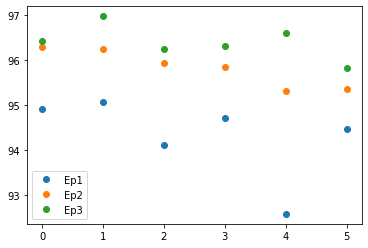

In [35]:
accs = [[94.91,96.30,96.42],[95.07,96.24,96.98],[94.12,95.94,96.24],[94.72,95.85,96.31],[92.58,95.31,96.60],[94.46,95.37,95.83]]
plt.plot(range(6), [a[0] for a in accs], linestyle="", marker="o", label="Ep1")
plt.plot(range(6), [a[1] for a in accs], linestyle="", marker="o", label="Ep2")
plt.plot(range(6), [a[2] for a in accs], linestyle="", marker="o", label="Ep3")
plt.legend()
plt.show()